In [1]:
from sample import simple_sample_generator
from estimators import ClusteredSegmentation
from BarcodeScanner import cluster_barcode_scanner
import pandas as pd
import numpy as np
from sklearn.metrics import auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
import random
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, RocCurveDisplay
def distance_simulation(sample_size, num_variables):
    rng = simple_sample_generator(num_variables, sample_size, 2) # num_interactions is 2
    cluster = ClusteredSegmentation(n_clusters = num_variables + 3)
    cluster.fit(rng.barcode.reshape(-1,1), rng.y)
    scanner = cluster_barcode_scanner(rng, cluster, False) # <- need to change to False later
#     scanner.set_beta_sum_range(1, 2)
    ranking_table = scanner.get_distance_ranking(0, normalize = False)
#     ranking_table = scanner.cdf_ranking
    true_parameters = [x.replace('X','beta') for x in rng.interactions.keys()]
    actual = ranking_table.coefficients.isin(true_parameters)
    predicted = ranking_table.ranking.isin(list(range(1, 3)))
    return (actual.to_numpy(), predicted.to_numpy())


def fisher_simulation(sample_size, num_variables):
    rng = simple_sample_generator(num_variables, sample_size, 2) # num_interactions is 2
    cluster = ClusteredSegmentation(n_clusters = 2**num_variables)
    cluster.fit(rng.barcode.reshape(-1,1), rng.y)
    scanner = cluster_barcode_scanner(rng, cluster, False) # <- need to change to False later
    scanner.set_beta_sum_range(1, 2)
#     ranking_table = scanner.get_distance_ranking(0, normalize = False)
    ranking_table = scanner.cdf_ranking
    true_parameters = [x.replace('X','beta') for x in rng.interactions.keys()]
    actual = ranking_table.coefficients.isin(true_parameters)
    predicted = ranking_table.ranking.isin(list(range(1, 3)))
    return (actual.to_numpy(), predicted.to_numpy(), ranking_table)

## Sampling Condition: 

* sample size : 5,000
* number of binary variables : 4
* coefficients for $\beta$'s: 1
* number of interactions : 2
* error variance : 1
* iterations : 300

In [3]:
sample_size = 5000; num_variables = 4

distance_result = Parallel(n_jobs = -1, verbose = 10)(delayed(distance_simulation)(
    sample_size = sample_size, num_variables = num_variables) for _ in range(300))
fisher_result = Parallel(n_jobs = -1, verbose = 10)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables) for _ in range(300))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  

In [4]:
distance_prediction = [r[1] for r in distance_result]
distance_actual = [r[0] for r in distance_result]

fisher_prediction = [r[1] for r in fisher_result]
fisher_actual = [r[0] for r in fisher_result]

In [11]:
from sklearn.metrics import roc_auc_score
mean_auc_score_distance = np.mean([roc_auc_score(x, y) for x,y in zip(distance_actual, distance_prediction)])
mean_auc_score_fisher = np.mean([roc_auc_score(x, y) for x,y in zip(fisher_actual, fisher_prediction)])

In [13]:
mean_auc_score_distance, mean_auc_score_fisher

(0.5100925925925925, 0.9969444444444445)

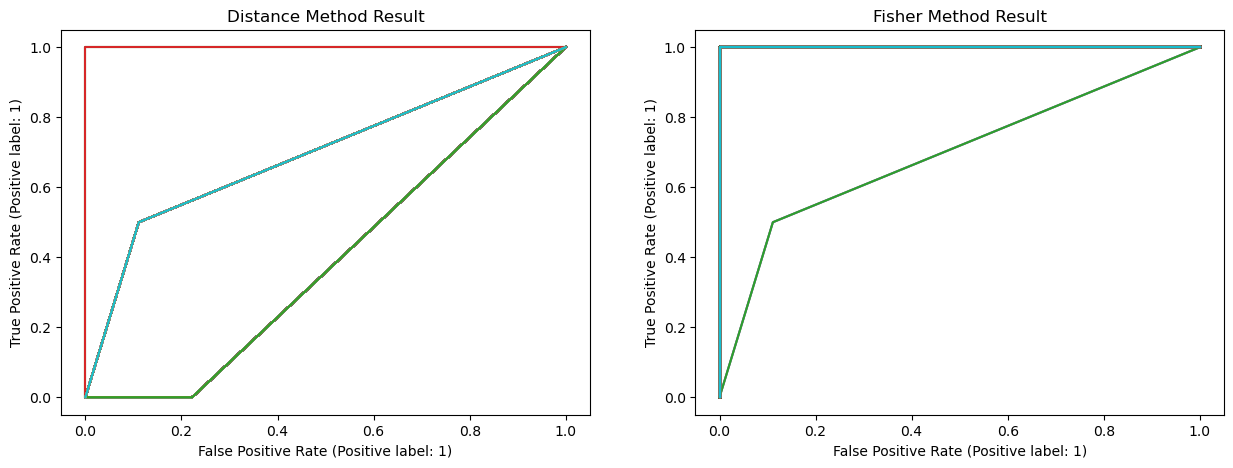

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for x_dist, y_dist, x_fisher, y_fisher in zip(distance_actual, distance_prediction, fisher_actual, fisher_prediction):
    RocCurveDisplay.from_predictions(x_dist,y_dist, ax = ax[0])
    RocCurveDisplay.from_predictions(x_fisher,y_fisher, ax = ax[1])
#     RocCurveDisplay.from_predictions(distance_actual,distance_prediction, ax = ax[0])
#     RocCurveDisplay.from_predictions(fisher_actual,fisher_prediction, ax = ax[1])
ax[0].set_title('Distance Method Result'); ax[1].set_title('Fisher Method Result')
ax[0].legend().set_visible(False); ax[1].legend().set_visible(False)

plt.show()

In [ ]:
distance_prediction = np.concatenate([r[1] for r in distance_result])
distance_actual = np.concatenate([r[0] for r in distance_result])

fisher_prediction = np.concatenate([r[1] for r in fisher_result])
fisher_actual = np.concatenate([r[0] for r in fisher_result])

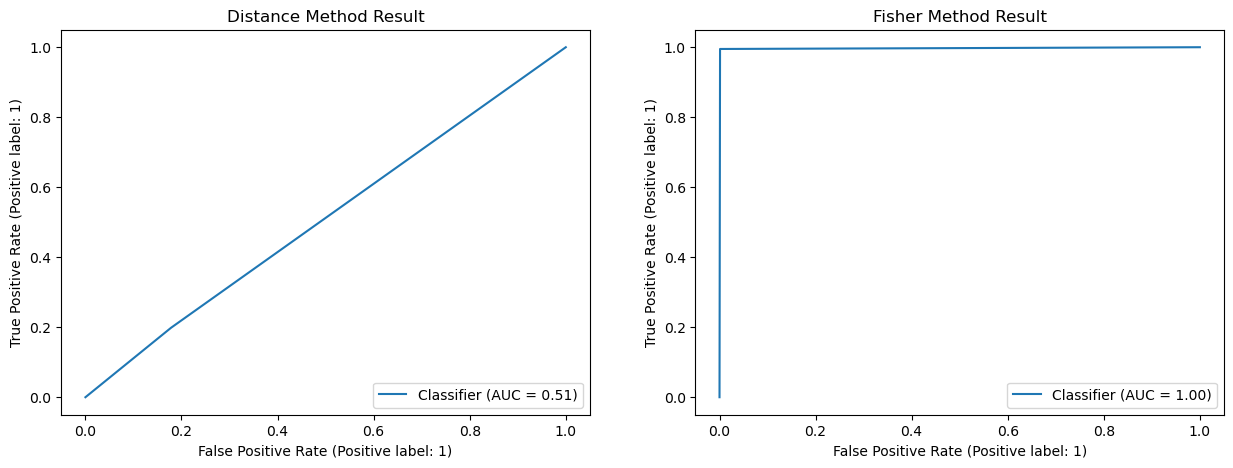

In [94]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

RocCurveDisplay.from_predictions(distance_actual,distance_prediction, ax = ax[0])
RocCurveDisplay.from_predictions(fisher_actual,fisher_prediction, ax = ax[1])
ax[0].set_title('Distance Method Result'); ax[1].set_title('Fisher Method Result')
plt.show()

## Sampling Condition: 

* sample size : 5,000
* number of binary variables : 4
* coefficients for $\beta$'s: **3**
* number of interactions : 2
* error variance : 1
* iterations : 300

In [97]:
def distance_simulation(sample_size, num_variables):
    rng = simple_sample_generator(num_variables, sample_size, 2, beta_range = (3,3)) # num_interactions is 2
    cluster = ClusteredSegmentation(n_clusters = num_variables + 3)
    cluster.fit(rng.barcode.reshape(-1,1), rng.y)
    scanner = cluster_barcode_scanner(rng, cluster, False) # <- need to change to False later
#     scanner.set_beta_sum_range(1, 2)
    ranking_table = scanner.get_distance_ranking(0, normalize = False)
#     ranking_table = scanner.cdf_ranking
    true_parameters = [x.replace('X','beta') for x in rng.interactions.keys()]
    actual = ranking_table.coefficients.isin(true_parameters)
    predicted = ranking_table.ranking.isin(list(range(1, 3)))
    return (actual.to_numpy(), predicted.to_numpy())


def fisher_simulation(sample_size, num_variables):
    rng = simple_sample_generator(num_variables, sample_size, 2, beta_range = (3,3)) # num_interactions is 2
    cluster = ClusteredSegmentation(n_clusters = 2**num_variables)
    cluster.fit(rng.barcode.reshape(-1,1), rng.y)
    scanner = cluster_barcode_scanner(rng, cluster, False) # <- need to change to False later
    scanner.set_beta_sum_range(1, 2)
#     ranking_table = scanner.get_distance_ranking(0, normalize = False)
    ranking_table = scanner.cdf_ranking
    true_parameters = [x.replace('X','beta') for x in rng.interactions.keys()]
    actual = ranking_table.coefficients.isin(true_parameters)
    predicted = ranking_table.ranking.isin(list(range(1, 3)))
    return (actual.to_numpy(), predicted.to_numpy(), ranking_table)

In [99]:
sample_size = 5000; num_variables = 4

distance_result = Parallel(n_jobs = -1, verbose = 1)(delayed(distance_simulation)(
    sample_size = sample_size, num_variables = num_variables) for _ in range(300))
fisher_result = Parallel(n_jobs = -1, verbose = 1)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables) for _ in range(300))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


In [100]:
distance_prediction = np.concatenate([r[1] for r in distance_result])
distance_actual = np.concatenate([r[0] for r in distance_result])

fisher_prediction = np.concatenate([r[1] for r in fisher_result])
fisher_actual = np.concatenate([r[0] for r in fisher_result])

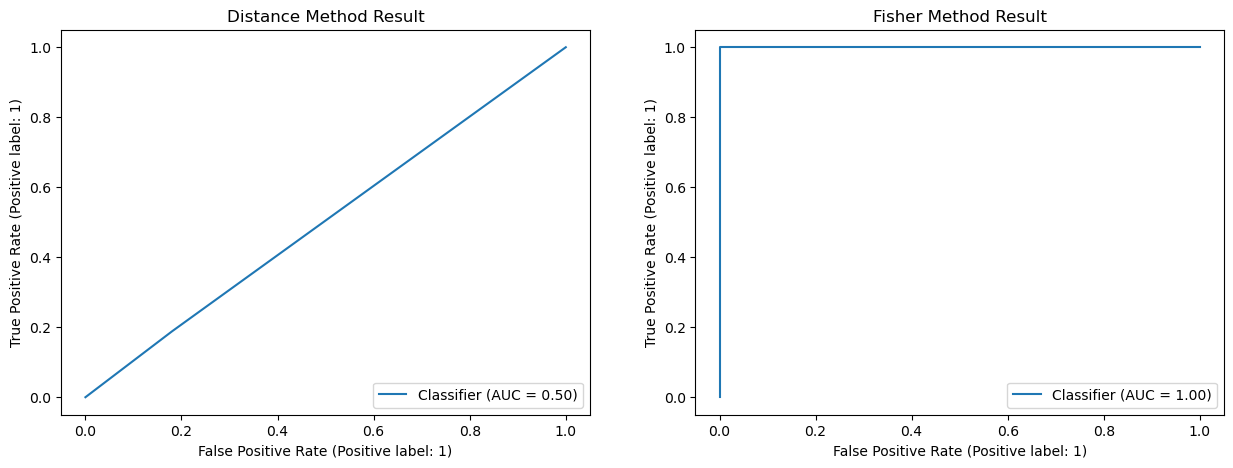

In [101]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

RocCurveDisplay.from_predictions(distance_actual,distance_prediction, ax = ax[0])
RocCurveDisplay.from_predictions(fisher_actual,fisher_prediction, ax = ax[1])
ax[0].set_title('Distance Method Result'); ax[1].set_title('Fisher Method Result')
plt.show()

## Sampling Condition: 

* sample size : 10,000
* number of binary variables : 5
* coefficients for $\beta$'s: 1
* number of interactions : 16
* error variance : 1
* iterations : 100

In [106]:
def fisher_simulation(sample_size, num_variables):
    rng = simple_sample_generator(num_variables, sample_size, 16) # num_interactions is 2
    cluster = ClusteredSegmentation(n_clusters = 2**num_variables)
    cluster.fit(rng.barcode.reshape(-1,1), rng.y)
    scanner = cluster_barcode_scanner(rng, cluster, False) # <- need to change to False later
    scanner.set_beta_sum_range(1, 2)
#     ranking_table = scanner.get_distance_ranking(0, normalize = False)
    ranking_table = scanner.cdf_ranking
    true_parameters = [x.replace('X','beta') for x in rng.interactions.keys()]
    actual = ranking_table.coefficients.isin(true_parameters)
    predicted = ranking_table.ranking.isin(list(range(1, 17)))
    return (actual.to_numpy(), predicted.to_numpy(), ranking_table)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.9min finished


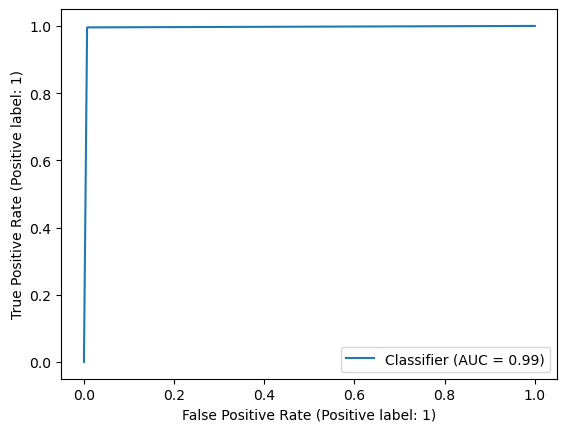

In [107]:
sample_size = 10_000; num_variables = 5

fisher_result = Parallel(n_jobs = -1, verbose = 1)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables) for _ in range(100))
fisher_prediction = np.concatenate([r[1] for r in fisher_result])
fisher_actual = np.concatenate([r[0] for r in fisher_result])
RocCurveDisplay.from_predictions(fisher_actual,fisher_prediction)

Increase the variance until I see the performance slows down

Check how the ROC is calculated

Run through of a clustering method

In [26]:
def fisher_simulation(sample_size, num_variables, error_scale):
    rng = simple_sample_generator(num_variables, sample_size, 2, error_scale = error_scale) # num_interactions is 2
    cluster = ClusteredSegmentation(n_clusters = 2**num_variables)
    cluster.fit(rng.barcode.reshape(-1,1), rng.y)
    scanner = cluster_barcode_scanner(rng, cluster, False) # <- need to change to False later
    scanner.set_beta_sum_range(1, 2)
#     ranking_table = scanner.get_distance_ranking(0, normalize = False)
    ranking_table = scanner.cdf_ranking
    true_parameters = [x.replace('X','beta') for x in rng.interactions.keys()]
    actual = ranking_table.coefficients.isin(true_parameters)
    predicted = ranking_table.ranking.isin(list(range(1, 3)))
    return (actual.to_numpy(), predicted.to_numpy(), ranking_table)

When $\sigma$ = 2

In [73]:
sample_size = 5000; num_variables = 4; error_scale = 2

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [74]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

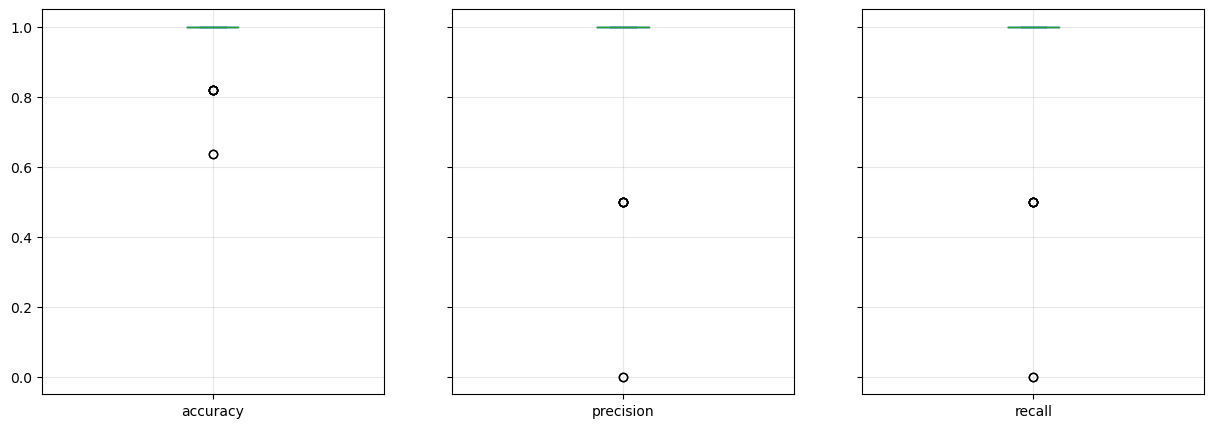

In [75]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 3

In [76]:
sample_size = 5000; num_variables = 4; error_scale = 3

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [77]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

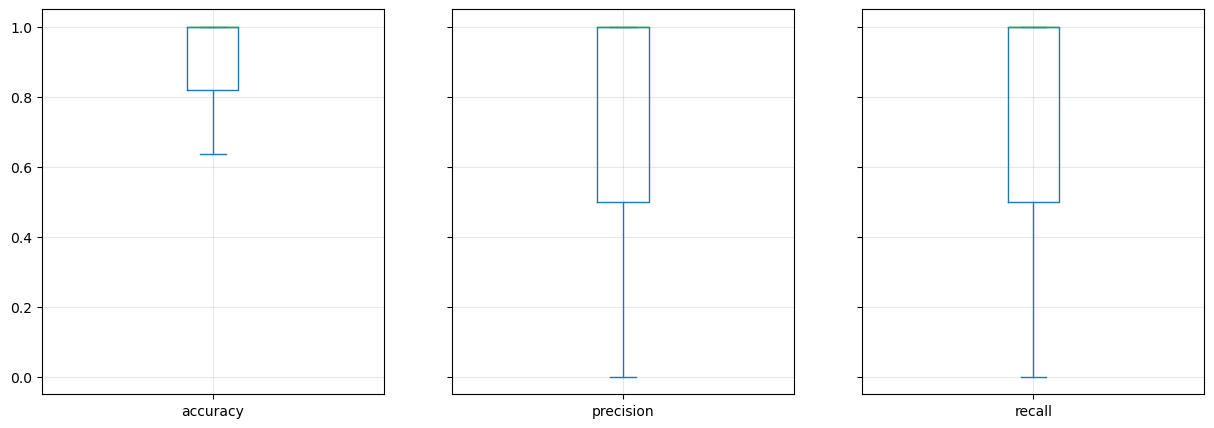

In [78]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 4

In [79]:
sample_size = 5000; num_variables = 4; error_scale = 4

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [80]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

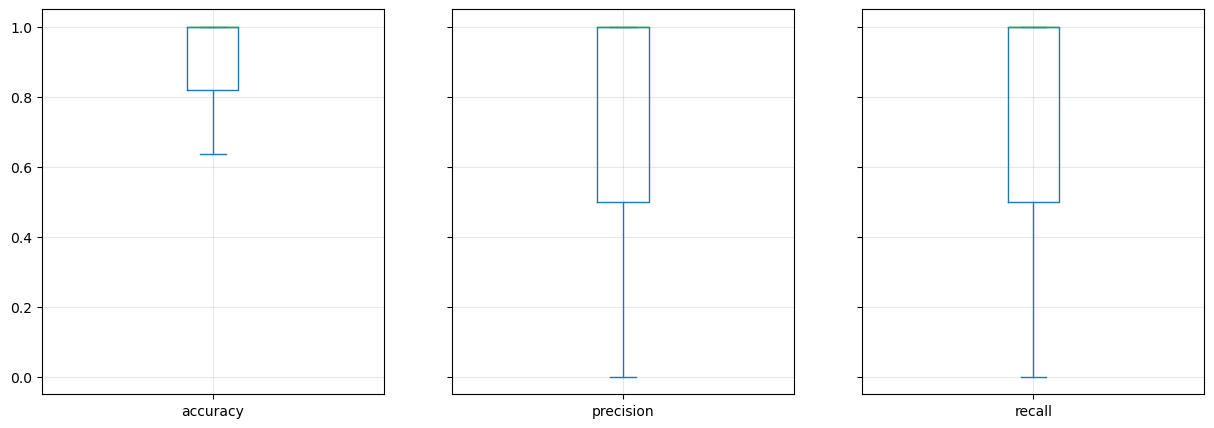

In [81]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 5

In [82]:
sample_size = 5000; num_variables = 4; error_scale = 5

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [83]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

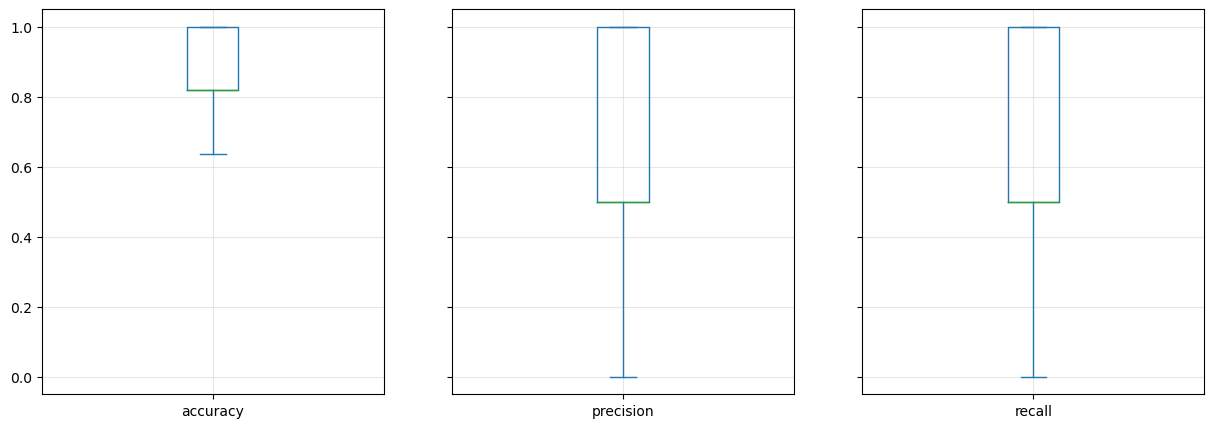

In [84]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 6

In [85]:
sample_size = 5000; num_variables = 4; error_scale = 6

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [86]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

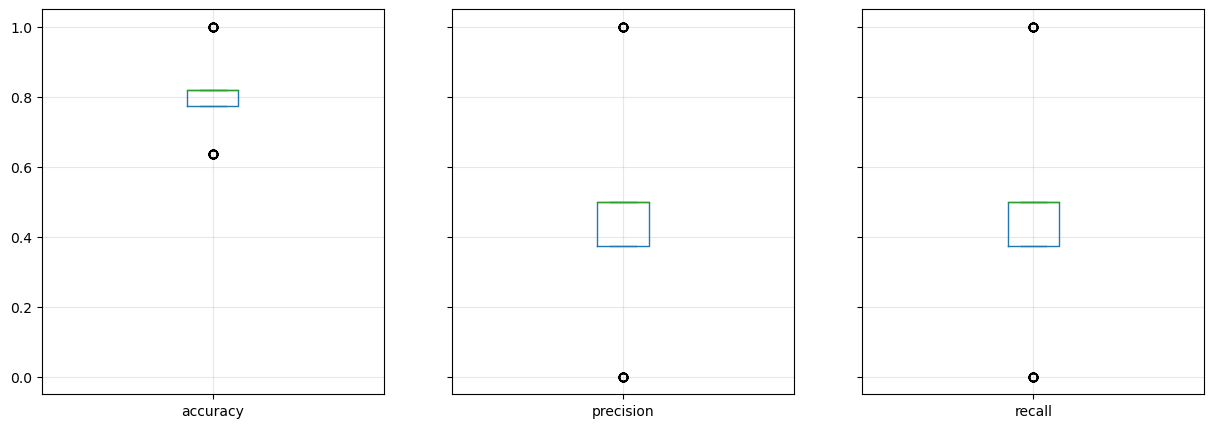

In [87]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 7

In [88]:
sample_size = 5000; num_variables = 4; error_scale = 7

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [89]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

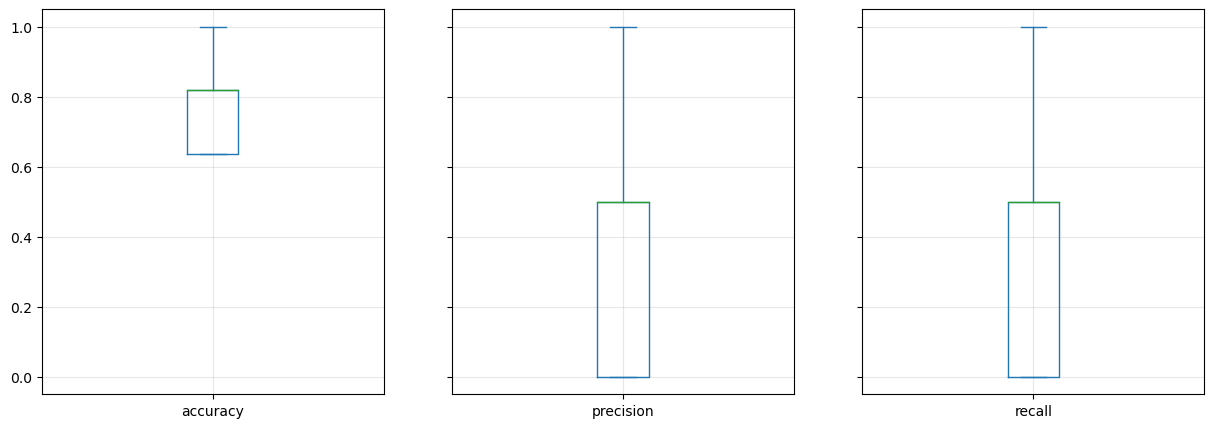

In [90]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 8

In [91]:
sample_size = 5000; num_variables = 4; error_scale = 8

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [92]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

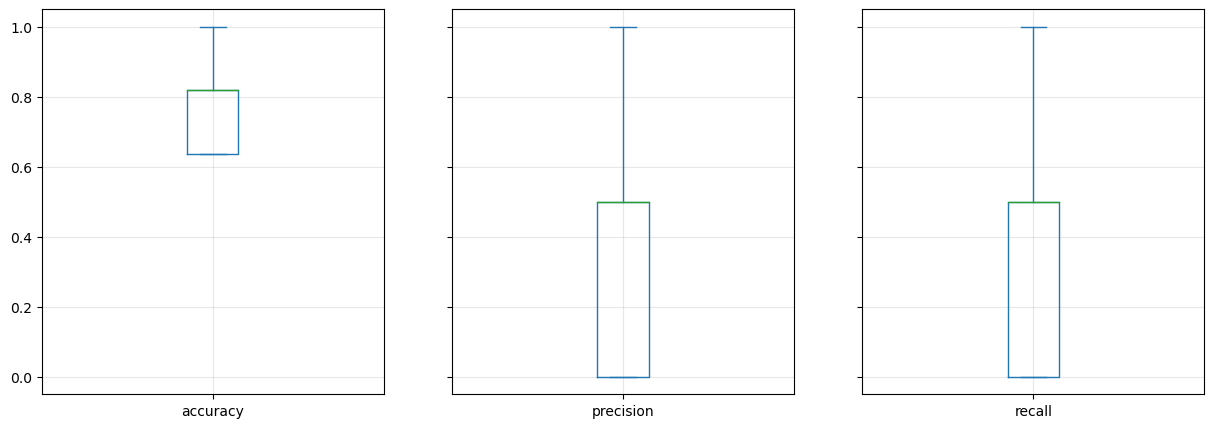

In [93]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 9

In [94]:
sample_size = 5000; num_variables = 4; error_scale = 9

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [95]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

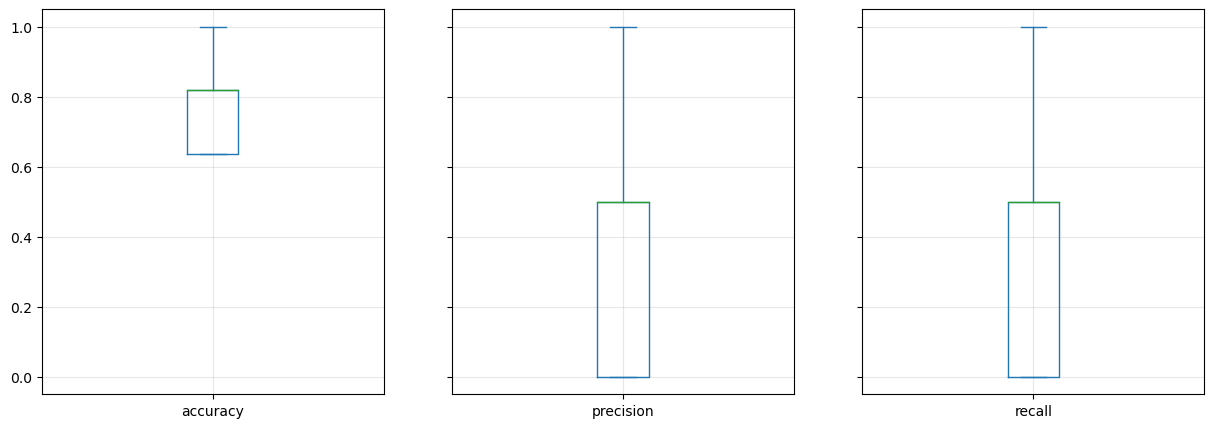

In [96]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()

When $\sigma$ = 10

In [97]:
sample_size = 5000; num_variables = 4; error_scale = 10

fisher_result = Parallel(n_jobs = -1, verbose = 0)(delayed(fisher_simulation)(
    sample_size = sample_size, num_variables = num_variables, error_scale = error_scale) for _ in range(100))


In [98]:
from sklearn.metrics import confusion_matrix
def return_metrics(result):
    tn, fp, fn, tp = confusion_matrix(result[0], result[1]).ravel()
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return [accuracy, precision, recall]

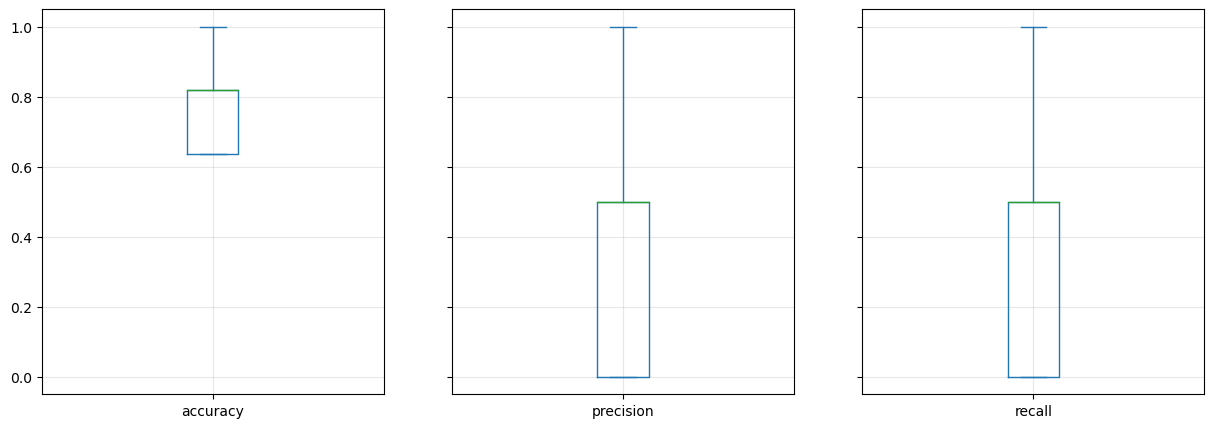

In [99]:
metrics = pd.DataFrame([return_metrics(r) for r in fisher_result], columns = ['accuracy','precision','recall'])
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
for i, col in enumerate(metrics.columns):
    metrics[col].plot.box(ax = ax[i])
    ax[i].grid(alpha = .3)
plt.show()